In [0]:
# Automatically reload external libraries that change
%reload_ext autoreload
%autoreload 2

# If a matplotlib plot command is issued, display the results in the notebook
%matplotlib inline

In [2]:
# Upload data
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [3]:
!tar xvzf track_shower_images.tar.gz

Images/
Images/Hits/
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_0_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_100_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_101_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_102_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_103_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_104_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_105_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_106_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_107_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_108_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_109_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_10_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_110_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_111_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_112_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_113_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_114_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_115_0.png
Images/Hits/Image_DUNEFD_MC1

In [0]:
# Reduce to just 100 images
#!rm -f Images/Truth/Image*_[0-9][0-9][0-9]_0.png
#!rm -f Images/Hits/Image*_[0-9][0-9][0-9]_0.png
#!rm -f *.py

In [5]:
# Upload supporting python modules
!rm -f *.py
from google.colab import files
files.upload()
from data import SegmentationBunch
from transforms import Rescale, ToTensor
from unet import UNet
import img_util as iu
import model_util as mu

Saving data.py to data.py
Saving img_util.py to img_util.py
Saving model_util.py to model_util.py
Saving transforms.py to transforms.py
Saving unet.py to unet.py


In [0]:
from data import open_image
img = open_image("Images/Truth/Image_DUNEFD_MC11_CaloHitListW_0_0.png")

In [7]:
img.size

(512, 208)

In [0]:
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.optim as opt
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [0]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
#bunch = SegmentationBunch("Images", "Hits", "Truth", batch_size=64, valid_pct = 0.2,
#    transform=transforms.Compose([Rescale((512, 208)), ToTensor()]))
bunch = SegmentationBunch("Images", "Hits", "Truth", batch_size=48, valid_pct = 0.2,
    transform=transforms.Compose([ToTensor(True)]))

In [0]:
count = {0: 0, 1: 0, 2: 0}
for batch in bunch.train_dl:
    images, masks = batch
    unique, counts = torch.unique(masks, return_counts=True)
    unique = [ u.item() for u in unique ]
    counts = [ c.item() for c in counts ]
    this_dict = dict(zip(unique, counts))
    for key in this_dict:
            count[key] += this_dict[key]

In [45]:
count
# There are 95973 shower hits and 127659 track hits in the training data set (last batch dropped)

{0: 81565296, 1: 95973, 2: 127659}

In [0]:
count = {0: 0, 1: 0, 2: 0}
for batch in bunch.valid_dl:
    images, masks = batch
    unique, counts = torch.unique(masks, return_counts=True)
    unique = [ u.item() for u in unique ]
    counts = [ c.item() for c in counts ]
    this_dict = dict(zip(unique, counts))
    for key in this_dict:
            count[key] += this_dict[key]

In [47]:
count
# Theere are 22308 shower hits and 32958 track hits in the validation set (relatively more tracks)

{0: 20392879, 1: 22073, 2: 32280}

In [0]:
void_code = 0

def accuracy(input, truth):
    target = truth.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

SHOWER = 1
TRACK = 2
def type_accuracy(input, truth, type):
    target = truth.squeeze(1)
    mask = target == type
    #print("Target shape:", target.shape)
    #print("Mask shape:", mask.shape)
    typestr = "SHOWER" if type == SHOWER else "TRACK"
    #print(f"Num mask {typestr} = {torch.sum(mask)}")
    #print(f"Num input {typestr} = {torch.sum(input.argmax(dim=1)[target != void_code] == type)}")
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

# Write some unit tests for this function using numpy arrays to check it is
# behaving correctly - get the shape of input and target to match dimensionality

In [48]:
# Create the network, loss function and optimizer
n_classes = 3
model = UNet(1, n_classes = n_classes, n_filters = 16, y_range = (0, n_classes))
#print(model)
num_shower_hits = 95973.0
num_track_hits = 127659.0
# Invert weighting to balance affect on loss function
shower_weight = num_track_hits / (num_shower_hits + num_track_hits)
track_weight = num_shower_hits / (num_shower_hits + num_track_hits)
print("Weights:", shower_weight, track_weight)
loss_fn = nn.CrossEntropyLoss(torch.tensor([0., shower_weight, track_weight]))
#optim = opt.Adam(model.parameters())
#optim = opt.Adam(model.parameters(), lr=2e-4)
#optim = opt.Adam(model.parameters(), lr=1e-4)
# Smoothest training, consistent with lr_finder
#optim = opt.Adam(model.parameters(), lr=1.5e-4)
#optim = opt.Adam(model.parameters(), lr=1.5e-4, weight_decay=0.1)
# New but untested, may also want to add weight decay to lr_finder,
# Might be worth testing a max of 2e-3 as well
#max_lr = 1e-3
max_lr = 1e-3
optim = opt.Adam(model.parameters(), lr=max_lr, weight_decay=0.1)
from torch.optim.lr_scheduler import OneCycleLR
# Want a cleaner way to get the number of batches
num_epochs = 2
#scheduler = OneCycleLR(optim, max_lr, total_steps=len(bunch.train_dl) * num_epochs)
#scheduler = OneCycleLR(optim, max_lr, total_steps=len(bunch.train_dl) * num_epochs, div_factor=10.0)
#scheduler = OneCycleLR(optim, max_lr, total_steps=len(bunch.train_dl) * num_epochs, div_factor=10.0)
#scheduler = OneCycleLR(optim, max_lr, total_steps=len(bunch.train_dl) * num_epochs, div_factor=2.0)
#scheduler = OneCycleLR(optim, max_lr*10, total_steps=len(bunch.train_dl) * num_epochs, pct_start=0.2, div_factor=10.0)
scheduler = OneCycleLR(optim, max_lr * 2, anneal_strategy='linear', epochs=num_epochs, steps_per_epoch=len(bunch.train_dl), pct_start=0.05, div_factor=2.0)
# maybbe change final_div_factor too, because div by 10K is probably massive overkill for short runs
# Temp scheduler to not change rate
#from torch.optim.lr_scheduler import LambdaLR
#scheduler = LambdaLR(optim, lambda epoch: 10.)

Weights: 0.5708440652500537 0.42915593474994634


In [0]:
# Find learning rate
#optim = opt.Adam(model.parameters(), lr=1e-7)
#num_iter = 100
#lr_lambda = lambda batch : get_running_factor(1e-7, 10, num_iter, batch)
min_lr = 1e-5
max_lr = 1
optim = opt.Adam(model.parameters(), lr=min_lr)
num_iter = 40
lr_lambda = lambda batch : get_running_factor(min_lr, max_lr, num_iter, batch)
lr_finder = mu.LRFinder(optim=optim, num_iter=num_iter)
lr_finder.find(model=model, input=bunch.train_dl, loss_fn=loss_fn)

In [0]:
learning_rates = lr_finder.get_learning_rates()
train_loss_epochs = lr_finder.get_losses()

In [0]:
print(learning_rates)

In [0]:
def plot_lr(x, y, name, labels=("lr", "Loss")):
    fig, ax = plt.subplots()
    ax.set_title('Learning Rate Finder')
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.plot(x, y, c='darkred')
    iu.save_figure(fig, name)

In [0]:
plot_lr(learning_rates, train_loss_epochs, "LossByLearningRate")
plot_lr(learning_rates[:55], train_loss_epochs[:55], "LossByLearningRate")
plot_lr(list(range(len(learning_rates))), train_loss_epochs, "LossByLearningRate", ("Batch", "Loss"))

In [0]:
!tar cvzf images.tar.gz *.png *.pdf *.eps

LossByBatch.png
LossByLearningRate.png
LossByLearningRateZoom.png
LossByBatch.pdf
LossByLearningRate.pdf
LossByLearningRateZoom.pdf
LossByBatch.eps
LossByLearningRate.eps
LossByLearningRateZoom.eps


In [0]:
files.download("images.tar.gz")

In [0]:
class EpochStats:
    def __init__(self, classes=[SHOWER, TRACK]):
        self.loss = []
        self.accuracy = []
        self.class_accuracy = { key : [] for key in classes }

    def add_loss(self, loss):
        self.loss.append(loss)
    
    def add_accuracy(self, acc, cls=None):
        if cls is None:
            self.accuracy.append(acc)
        else:
            self.class_accuracy[cls].append(acc)

    def get_losses(self):
        return np.array(self.loss)
    
    def get_accuracies(self, cls=None):
        if cls is None:
            return np.array(self.accuracy)
        else:
            return np.array(self.class_accuracy[cls])

class TrainingInfo:
    def __init__(self):
        self.learning_rates = []

def one_epoch(epoch, model, optim, scheduler, dl, training):
    stats = EpochStats()
    info = TrainingInfo()
    for i, batch in enumerate(dl):
        images, masks = batch
        x = Variable(images)
        y = Variable(masks)
        pred = model.forward(x)

        loss = loss_fn(pred, y)
        stats.add_loss(loss.item())

        acc = accuracy(pred, y)
        track_acc = type_accuracy(pred, y, TRACK)
        shower_acc = type_accuracy(pred, y, SHOWER)
        stats.add_accuracy(acc)
        stats.add_accuracy(track_acc, TRACK)
        stats.add_accuracy(shower_acc, SHOWER)

        # Just one learning rate for now
        info.learning_rates.append(scheduler.get_lr()[0])

        if i == (len(dl) - 1):
            net_input = x.detach().numpy()
            net_pred = pred.detach().numpy()
            net_mask = y.detach().numpy()
            iu.show_batch(epoch, i, net_input, net_pred, net_mask, void_code, training, n=3, randomize=True)
        
        print("Batch {} [{}]: Train Loss: {}   Train Acc: {}   S Acc: {} T Acc: {}".format(
            i + 1, info.learning_rates[-1], loss.item(), acc, shower_acc, track_acc))

        if training:
            loss.backward()
            optim.step()
            scheduler.step()
            optim.zero_grad()
    return stats, info

***Training***
Batch 1 [0.001]: Train Loss: 1.5206915140151978   Train Acc: 0.22248438000679016   S Acc: 0.17015774548053741 T Acc: 0.2831036448478699
Batch 2 [0.0019736855263157893]: Train Loss: 1.0784523487091064   Train Acc: 0.5154472589492798   S Acc: 0.4444597661495209 T Acc: 0.5779939293861389
Batch 3 [0.0019078993421052632]: Train Loss: 0.8534265756607056   Train Acc: 0.6741428375244141   S Acc: 0.578830897808075 T Acc: 0.7344059944152832
Batch 4 [0.0018421131578947368]: Train Loss: 0.7374985814094543   Train Acc: 0.7075626850128174   S Acc: 0.5025709271430969 T Acc: 0.8517913222312927
Batch 5 [0.0017763269736842105]: Train Loss: 0.6729248762130737   Train Acc: 0.6908571124076843   S Acc: 0.40504807233810425 T Acc: 0.92767333984375
Batch 6 [0.0017105407894736843]: Train Loss: 0.5695557594299316   Train Acc: 0.7280152440071106   S Acc: 0.38371041417121887 T Acc: 0.9586300849914551
Batch 7 [0.0016447546052631577]: Train Loss: 0.543857216835022   Train Acc: 0.7502774000167847   S A

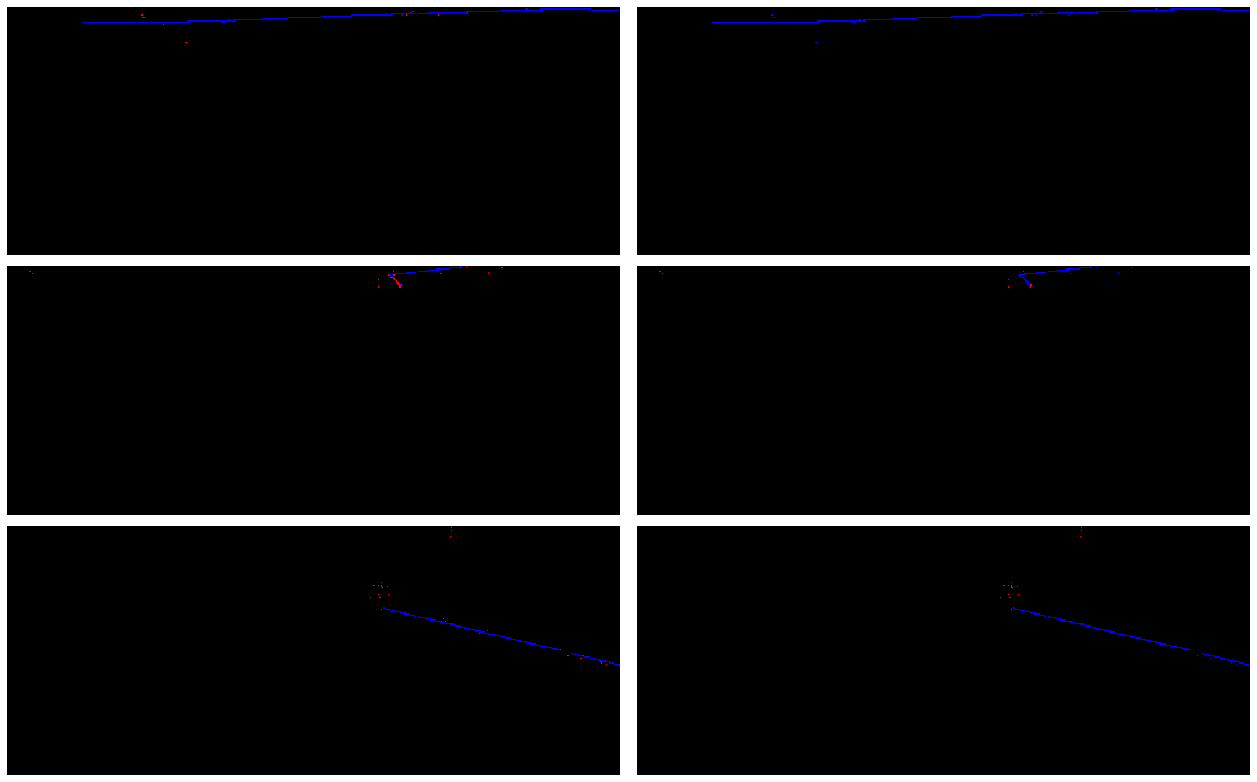

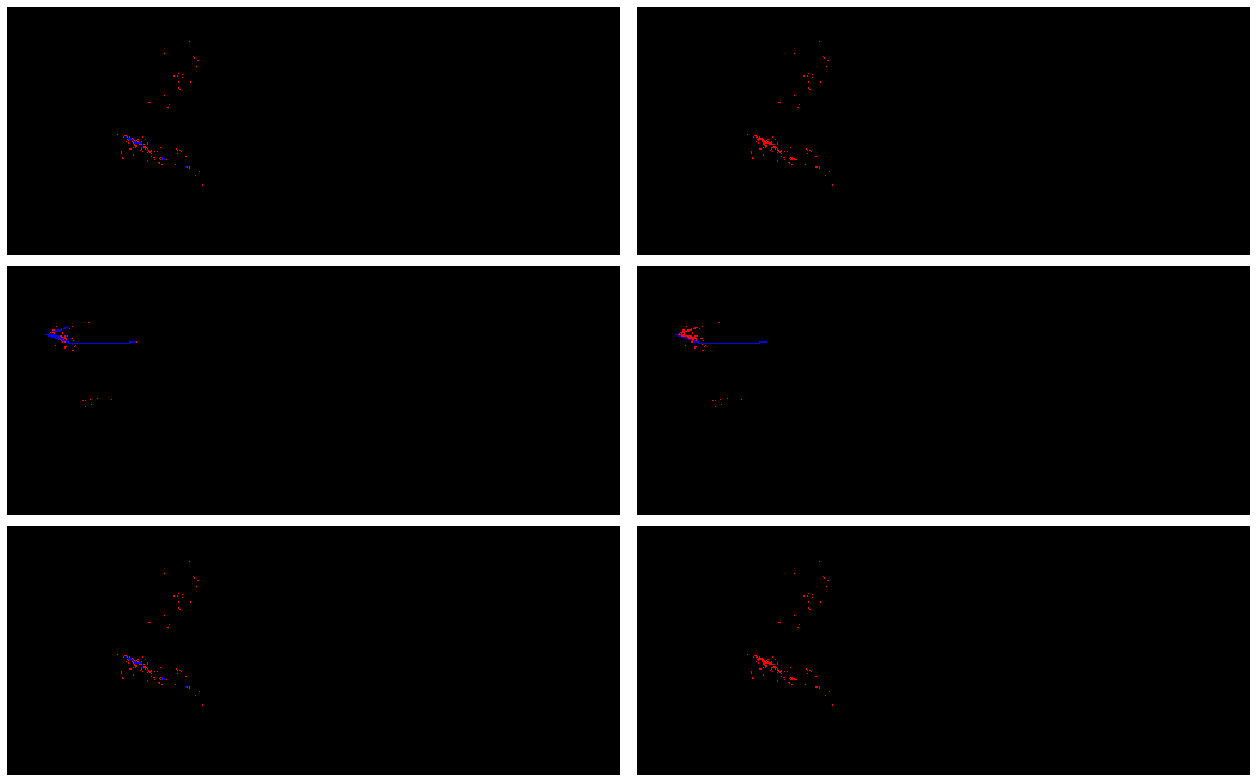

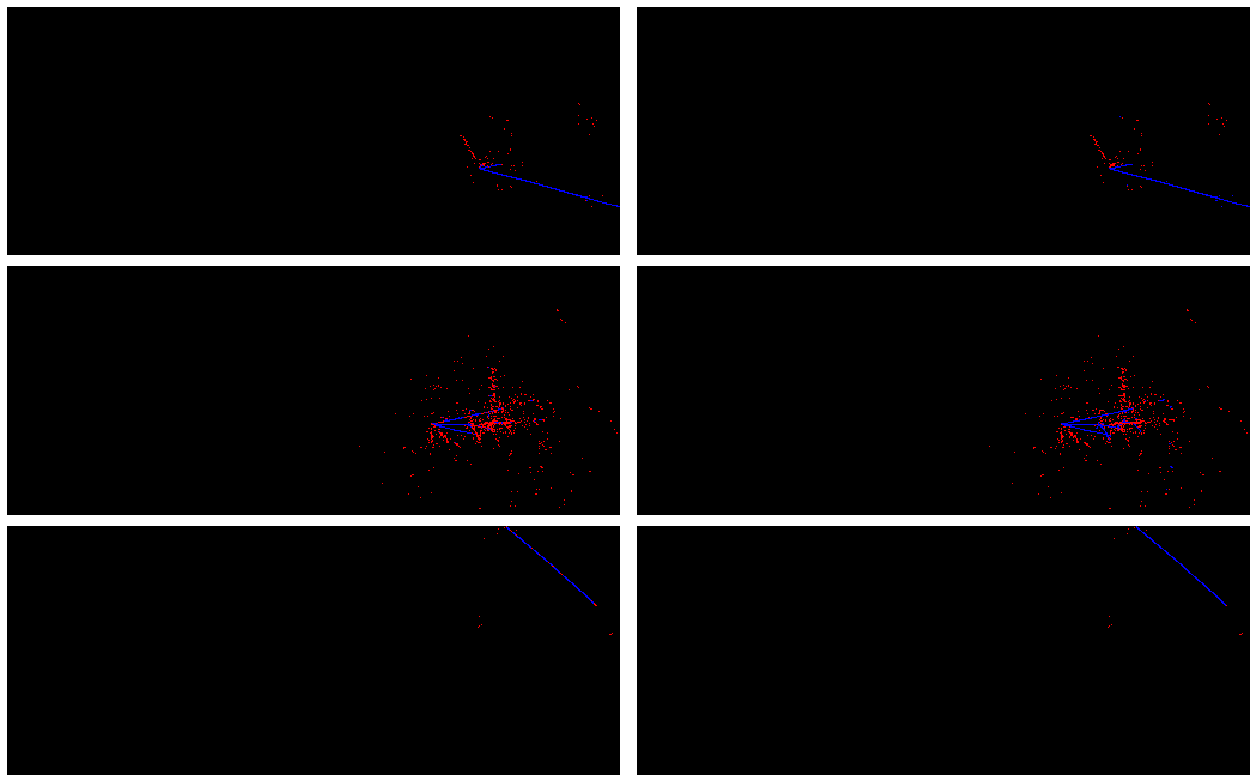

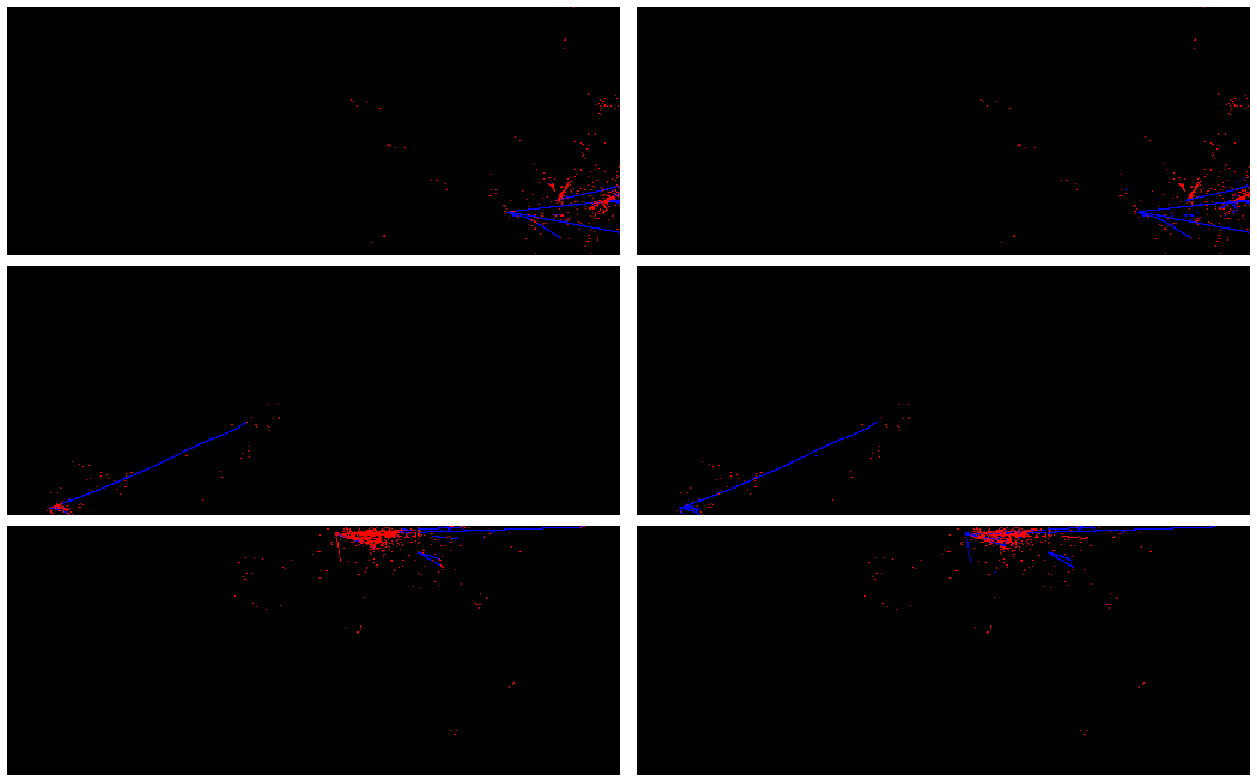

In [50]:
# Run
stats = [None] * num_epochs
info = [None] * num_epochs
val_stats = [None] * num_epochs
for epoch in list(range(0, num_epochs)):
    # Training
    print("***Training***")
    model = model.train()
    optim.zero_grad()
    stats[epoch], info[epoch] = one_epoch(epoch, model, optim, scheduler, bunch.train_dl, True)
    # Validation
    print("***Validating***")
    model = model.eval()

    for group in model.children():
        if type(group) == nn.Sequential:
            for child in group:
                if type(child)==nn.BatchNorm2d:
                    child.track_running_stats = False

    with torch.no_grad():
        val_stats[epoch], _ = one_epoch(epoch, model, optim, scheduler, bunch.valid_dl, False)
    print("Epoch {} : loss {} acc {}   val_loss {} val_acc {}:".format(
        epoch + 1, stats[epoch].get_losses().mean(), stats[epoch].get_accuracies().mean(),
        val_stats[epoch].get_losses().mean(), val_stats[epoch].get_accuracies().mean()))

In [0]:
def plot_lr_loss_acc(lrs, losses, accuracies, name):
    fig, axs = plt.subplots(3, 1, figsize=(6,9), sharex=True)
    xx = list(range(1, 1 + len(lrs)))
    yy = np.array([lrs, losses, accuracies])
    axes = ["lr", "loss", "acc"]
    labels = ["Overall", "Track", "Shower"]
    colors = ['black', 'blue', 'red']
    for i, ax in enumerate(axs):
        ax.set_xlabel("Batch")
        ax.set_ylabel(axes[i])
        if len(yy[i].shape) == 1:
            ax.plot(xx, yy[i], c='black')
        else:
            for j, y in enumerate(yy[i]):
                ax.plot(xx, y, c=colors[j], label=labels[j])
    for ax in axs: ax.label_outer()
    plt.tight_layout()
    plt.legend()
    iu.save_figure(fig, name)

In [0]:
batch_lrs = np.concatenate([i.learning_rates for i in info])
batch_losses = np.concatenate([s.get_losses() for s in stats])
batch_overall_accuracies = np.concatenate([s.get_accuracies() for s in stats])
batch_track_accuracies = np.concatenate([s.get_accuracies(TRACK) for s in stats])
batch_shower_accuracies = np.concatenate([s.get_accuracies(SHOWER) for s in stats])
batch_accuracies = np.array([batch_overall_accuracies, batch_track_accuracies, batch_shower_accuracies])

np.save("learning_rates", batch_lrs)
np.save("losses", batch_losses)
np.save("accuracies", batch_overall_accuracies)
np.save("track_accuracies", batch_track_accuracies)
np.save("shower_accuracies", batch_shower_accuracies)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


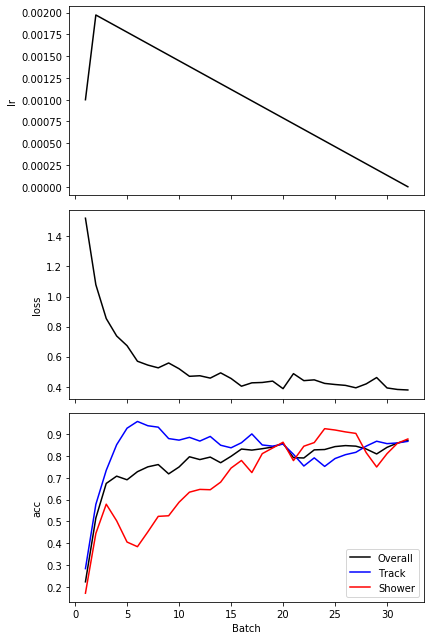

In [104]:
plot_lr_loss_acc(batch_lrs, batch_losses, batch_accuracies, "LRLossAcc")

In [0]:
# Upload pickle files
from google.colab import files
files.upload()

Saving flat_acc.npy to flat_acc.npy
Saving flat_losses.npy to flat_losses.npy
Saving flat_lr.npy to flat_lr.npy


{'flat_acc.npy': b"\x93NUMPY\x01\x00v\x00{'descr': '<f8', 'fortran_order': False, 'shape': (85,), }                                                           \n\x00\x00\x00`;\x8f\xe0?\x00\x00\x00`\x84\x1b\xe4?\x00\x00\x00\x80_r\xe7?\x00\x00\x00`=\xa3\xe6?\x00\x00\x00\x80\xbcU\xe7?\x00\x00\x00\x00\x1c\x88\xe8?\x00\x00\x00 Q9\xe8?\x00\x00\x00`\x00\xa1\xe8?\x00\x00\x00\xc0\xa5a\xea?\x00\x00\x00@\x10\xd5\xe9?\x00\x00\x00 c#\xe9?\x00\x00\x00\xe0\xae\x8b\xea?\x00\x00\x00\x80$\x80\xe9?\x00\x00\x00 \x03\xa6\xe9?\x00\x00\x00\xa0\x7f\xf7\xe9?\x00\x00\x00 \xb0o\xe9?\x00\x00\x00\xa0\xbfv\xea?\x00\x00\x00\xe08\x05\xea?\x00\x00\x00`\x1e\x90\xea?\x00\x00\x00\xa0?.\xeb?\x00\x00\x00\x80m\xbc\xea?\x00\x00\x00 \xec\xec\xe9?\x00\x00\x00\xc0\xdd\x16\xea?\x00\x00\x00 \xa2F\xea?\x00\x00\x00\x80\xa5\x16\xeb?\x00\x00\x00 \x91\xb9\xeb?\x00\x00\x00`\xd5\x99\xeb?\x00\x00\x00\x00q\xc0\xeb?\x00\x00\x00\xe0\xb9n\xeb?\x00\x00\x00`\x01h\xe9?\x00\x00\x00 \x84\r\xec?\x00\x00\x00 Ue\xec?\x00\x00\x00\x00\x92\x1e\xea?\x00\

In [0]:
# Upload some comparison data
import numpy as np
learning_rates = np.load("flat_lr.npy")
train_loss_batches = np.load("flat_losses.npy")
train_acc_batches = np.load("flat_acc.npy")

In [0]:
# Upload pickle files
!rm -f cycle_*.npy 
from google.colab import files
files.upload()

Saving cycle_acc.npy to cycle_acc.npy
Saving cycle_losses.npy to cycle_losses.npy
Saving cycle_lr.npy to cycle_lr.npy


{'cycle_acc.npy': b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<f8\', \'fortran_order\': False, \'shape\': (85,), }                                                           \n\x00\x00\x00\x80\x8f\x0b\xdf?\x00\x00\x00\xc0\xc8\x0c\xe6?\x00\x00\x00\xa0Z\x8b\xe7?\x00\x00\x00`R\x82\xe5?\x00\x00\x00`\xdc+\xe7?\x00\x00\x00\xc0\x99b\xe8?\x00\x00\x00\x00&\xe3\xe8?\x00\x00\x00@\xf6N\xe9?\x00\x00\x00\xc0\xefN\xea?\x00\x00\x00\xc0\xbd.\xeb?\x00\x00\x00 \x98C\xea?\x00\x00\x00@(\x01\xea?\x00\x00\x00\x00\x84\x96\xeb?\x00\x00\x00\xe02W\xeb?\x00\x00\x00 \xce\x13\xea?\x00\x00\x00\x00\x16\xbc\xeb?\x00\x00\x00\x00\x8f^\xe6?\x00\x00\x00 \xe1N\xeb?\x00\x00\x00@U\xe0\xe9?\x00\x00\x00 ~\xc4\xe9?\x00\x00\x00\x80\x97;\xea?\x00\x00\x00\x80\x18.\xea?\x00\x00\x00\x80W\\\xe8?\x00\x00\x00\x00&$\xeb?\x00\x00\x00`\xf29\xea?\x00\x00\x00\xa0O"\xea?\x00\x00\x00`\x9f\xc0\xea?\x00\x00\x00 \xceW\xeb?\x00\x00\x00\xa0D\xff\xe9?\x00\x00\x00 <\xfe\xe9?\x00\x00\x00@o\xa2\xeb?\x00\x00\x00\x80\xcb\x86\xeb?\x00\x00\x00@M\x10\xeb?\x00\x00

In [0]:
cycle_lr = np.load("cycle_lr.npy")
cycle_losses = np.load("cycle_losses.npy")
cycle_acc = np.load("cycle_acc.npy")

In [0]:
def plot_multi_lr_loss_acc(lrs, losses, accuracies, lrs2, losses2, acc2, name):
    fig, axs = plt.subplots(2, 1, sharex=True)
    xx = list(range(1, 1 + len(lrs)))
    yy_flat = [lrs, losses, accuracies]
    yy_cycle = [lrs2, losses2, acc2]
    xlabels = ["lr", "loss", "acc"]
    labels = ["Constant", "One-Cycle"]
    colors = [['black', 'black', 'black'],['red', 'red', 'red']]
    for i, ax in enumerate(axs):
        ax.set_xlabel("Batch")
        ax.set_ylabel(xlabels[i])
        ax.plot(xx, yy_flat[i], c=colors[0][i], label=labels[0])
        ax.plot(xx, yy_cycle[i], c=colors[1][i], label=labels[1])
    axs[0].legend()
    for ax in axs: ax.label_outer()
    plt.tight_layout()
    iu.save_figure(fig, name)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


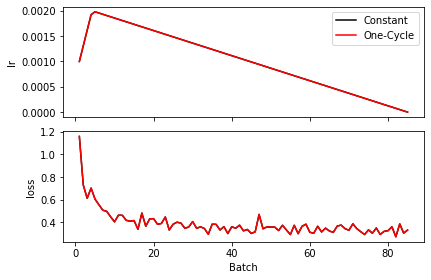

In [0]:
plot_multi_lr_loss_acc(learning_rates, train_loss_batches, train_acc_batches, cycle_lr, cycle_losses, cycle_acc, "MultiLRLossAcc")

In [0]:
#del x, y
#del images, masks
#del model
torch.cuda.empty_cache()

In [0]:
def plot_stat_epoch(train_stats, val_stats, stat="Loss"):
    epochs = np.array(list(range(1, len(train_stats) + 1)), dtype=np.int16)
    fig, ax = plt.subplots()
    ax.set_title(f'Model {stat}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(f'{stat}')
    ax.plot(epochs, train_stats, label='Training', c='red')
    ax.plot(epochs, val_stats, label='Validation', c='blue')
    if stat == "Loss": ax.legend(loc='upper right')
    else: ax.legend(loc='upper left')
    iu.save_figure(plt, f"Average{stat}VsTrainingEpoch")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


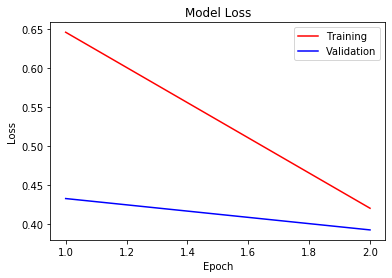

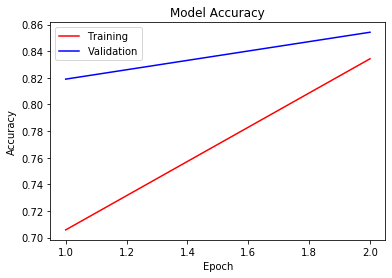

In [115]:
train_loss_epochs = [s.get_losses().mean() for s in stats]
val_loss_epochs = [s.get_losses().mean() for s in val_stats]
plot_stat_epoch(train_loss_epochs, val_loss_epochs)

train_acc_epochs = [s.get_accuracies().mean() for s in stats]
val_acc_epochs = [s.get_accuracies().mean() for s in val_stats]
plot_stat_epoch(train_acc_epochs, val_acc_epochs, stat="Accuracy")

In [117]:
!tar cvzf images.tar.gz *.png *.pdf *.eps *.npy
files.download("images.tar.gz")

AverageAccuracyVsTrainingEpoch.png
AverageLossVsTrainingEpoch.png
diagnostic_0_15.png
diagnostic_0_3.png
diagnostic_1_15.png
diagnostic_1_3.png
diagnostic_2_15.png
diagnostic_2_3.png
diagnostic_3_15.png
diagnostic_3_3.png
diagnostic_4_15.png
diagnostic_4_3.png
LRLossAcc.png
AverageAccuracyVsTrainingEpoch.pdf
AverageLossVsTrainingEpoch.pdf
diagnostic_0_15.pdf
diagnostic_0_3.pdf
diagnostic_1_15.pdf
diagnostic_1_3.pdf
diagnostic_2_15.pdf
diagnostic_2_3.pdf
diagnostic_3_15.pdf
diagnostic_3_3.pdf
diagnostic_4_15.pdf
diagnostic_4_3.pdf
LRLossAcc.pdf
AverageAccuracyVsTrainingEpoch.eps
AverageLossVsTrainingEpoch.eps
diagnostic_0_15.eps
diagnostic_0_3.eps
diagnostic_1_15.eps
diagnostic_1_3.eps
diagnostic_2_15.eps
diagnostic_2_3.eps
diagnostic_3_15.eps
diagnostic_3_3.eps
diagnostic_4_15.eps
diagnostic_4_3.eps
LRLossAcc.eps
accuracies.npy
learning_rates.npy
losses.npy
shower_accuracies.npy
track_accuracies.npy


In [0]:
!ls -l

total 1736
-rw-r--r-- 1 root   root    22490 Nov 14 13:22  AverageAccuracyVsTrainingEpoch.png
-rw-r--r-- 1 root   root    19800 Nov 14 13:22  AverageLossVsTrainingEpoch.png
-rw-r--r-- 1 root   root     3416 Nov 14 12:29 'data (1).py'
-rw-r--r-- 1 root   root     3416 Nov 14 12:12  data.py
drwxr-xr-x 4 197608 197121   4096 Nov 14 08:36  Images
drwxr-xr-x 2 root   root     4096 Nov 14 12:12  __pycache__
drwxr-xr-x 1 root   root     4096 Nov  6 16:17  sample_data
-rw-r--r-- 1 root   root   840513 Nov 14 12:29 'track_shower_images.tar (1).gz'
-rw-r--r-- 1 root   root   840513 Nov 14 12:12  track_shower_images.tar.gz
-rw-r--r-- 1 root   root     1264 Nov 14 12:29 'transforms (1).py'
-rw-r--r-- 1 root   root     1264 Nov 14 12:12  transforms.py
-rw-r--r-- 1 root   root     4289 Nov 14 12:29 'unet (1).py'
-rw-r--r-- 1 root   root     4289 Nov 14 12:12  unet.py


In [0]:
inp = torch.FloatTensor(
    [[ [ [0, 0, 255] , [255, 0, 0] , [255, 0, 255] ] ,   # Class 0
     [ [0, 0, 0] , [0, 0, 0] , [0, 255, 0] ] ,   # Class 1
     [ [255, 255, 0] , [0, 255, 255] , [0, 0, 0] ] ]] )  # Class 2
prediction = torch.FloatTensor(
    [[ [ [0, 0, 255] , [255, 0, 0] , [255, 0, 255] ] ,   # Class 0
     [ [0, 255, 0] , [0, 0, 0] , [0, 255, 0] ] ,   # Class 1
     [ [255, 0, 0] , [0, 255, 255] , [0, 0, 0] ] ]] )  # Class 2
truth = torch.LongTensor([[
    [2, 2, 0 ], 
    [0, 2, 2 ],
    [0, 1, 0 ]]])

In [0]:
print(prediction.shape)
print(truth.shape)

torch.Size([1, 3, 3, 3])
torch.Size([1, 3, 3])


In [0]:
vals = iu.imagify(inp, prediction, truth, 0, n=1, randomize=False)

Input shape torch.Size([1, 3, 3])
Truth shape torch.Size([1, 3, 3])
Pred shape torch.Size([1, 3, 3, 3])
[[[2 1 0]
  [0 2 2]
  [0 1 0]]]
tensor([[[2, 2, 0],
         [0, 2, 2],
         [0, 1, 0]]])


In [0]:
inp, pred, tru = vals

In [0]:
print(pred.shape)
print(tru.shape)

(1, 3, 3)
torch.Size([1, 3, 3])


In [0]:
acc = accuracy(torch.FloatTensor(prediction), truth)
acc = track_accuracy(torch.FloatTensor(prediction), truth)
acc

Shape: torch.Size([1, 3, 3])
Target: tensor([[[2, 2, 0],
         [0, 2, 2],
         [0, 1, 0]]])
Mask: tensor([[[ True,  True, False],
         [False,  True,  True],
         [False,  True, False]]])
Masked pred: tensor([2, 1, 2, 2, 1])
Masked mask: tensor([2, 2, 2, 2, 1])


tensor(0.7500)

In [0]:
print(pred)
print(tru)

[[[2 1 0]
  [0 2 2]
  [0 1 0]]]
tensor([[[2, 2, 0],
         [0, 2, 2],
         [0, 1, 0]]])


In [0]:
np.linspace(0,2,4)

array([0.        , 0.66666667, 1.33333333, 2.        ])

In [0]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [0]:
dump_tensors()

Total size: 0


/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: MODES has been renamed to Modes and will be removed in a future version of pywt.
